# Sommaire
* [Introduction](#introduction)
* [I) Initialisation MLFlow et importation des données](#i)
* [II) Régression logistique](#ii)
* [III) LightGBM](#iii)
* [IV) Exports](#iv)

# Introduction <a class="anchor" id="introduction"></a>
Dans ce notebook, on enchaîne sur l'entraînement des modèles avec les meilleurs hyperparamètres retenus précédemment, puis on les stocke sur le serveur MLFlow.

Nous allons également nous intéresser à la feature importance globale et locale.

# I) Initialisation MLFlow et importation des données <a class="anchor" id="i"></a>

In [1]:
#Pour initialiser le serveur MLFlow
import subprocess

#Commande pour lancer le serveur MLflow
cmd = ["mlflow", "server", "--host", "127.0.0.1", "--port", "5001"]

#On lance
process = subprocess.Popen(cmd)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('./Artefacts/data_final.parquet')
df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307503,456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307504,456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307505,456254,1.0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Même manoeuvre que dans l'autre notebook pour les NaNs
df_nona = df.fillna(df.mean())
df_nona

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,6.000000
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
307503,456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
307504,456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
307505,456254,1.0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605


# II) Régression logistique <a class="anchor" id="ii"></a>

In [5]:
import mlflow

#On récupère les runs pour l'expérience Logistic_regression
runs = mlflow.search_runs(experiment_names=["Logistic_regression"])

#On convertit en df et on filtre les métriques et paramètres
df_LR = pd.DataFrame(runs)
df_LR = df_LR.filter(regex=r'^(metrics\.|params\.)').sort_values(by="metrics.Score métier") #Rappel que le meilleur score métier est le score le plus faible
df_LR.head(10)

,metrics.Score métier,metrics.AUC,metrics.Recall,params.penalty,params.Threshold,params.C,params.Fit time
2,157439.0,0.770937,0.667553,None,0.5227258673530678,52.56679734794216,0:01:55
6,157455.0,0.770937,0.661954,None,0.5267171274560537,0.12165919973138103,0:01:57
18,157474.0,0.770954,0.660665,l1,0.5275263398569278,0.37527341675745984,0:03:53
34,157542.0,0.770937,0.661108,l1,0.5270654558724349,10.44034752240568,0:03:53
12,157580.0,0.770937,0.641934,None,0.5413702107688144,0.3265224437312339,0:01:56
1,157591.0,0.770937,0.646042,None,0.5382155194968478,170.7295830758564,0:01:54
48,157605.0,0.770937,0.657442,l1,0.5296347288274744,19.607284220170666,0:04:17
36,157633.0,0.770972,0.683061,l1,0.510711784154518,0.1946142440872025,0:03:49
22,157641.0,0.770953,0.685358,l1,0.5091287181442503,0.4197606348861592,0:03:50
17,157678.0,0.770979,0.686244,l1,0.5083799612165147,0.0929261537580304,0:03:49


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import gc
import time
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from datetime import timedelta

#Début du timer
start_time = time.time()

#Configuration initiale de MLFlow
mlflow.set_experiment('Best_models')

#On sépare en X et y
X = df_nona.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_nona['TARGET']

#On sépare en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#On centre et réduit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Pour récupérer le nombre de 0 et de 1 et définir les poids (qu'on utilise df ou df_nona revient au même ici)
target_counts = df['TARGET'].value_counts()
poids_classes = {0: 1, 1: target_counts.get(0) / target_counts.get(1)}

#Signature basée sur les données d'entrée et de sortie
signature = infer_signature(X_train_scaled, y_train)

#Liste vide pour enregistrer les résultats
resultats = []

#Le threshold pour plus tard (mlflow.log_param() enregistre les paramètres au format string)
threshold = float(df_LR["params.Threshold"].iloc[0])

#On instancie (pas besoin de conserver le reste des study.best_params car C n'a pas d'incidence quand penalty=None)
model_LR = LogisticRegression(penalty=None, solver='saga', tol=0.01, max_iter=1000, class_weight=poids_classes, random_state=42, verbose=0)

#On fit avec timer
start_fit_time = time.time()
model_LR.fit(X_train_scaled, y_train)
fit_time = time.time() - start_fit_time
fit_time = str(timedelta(seconds=int(fit_time)))

#On prédit le nombre de 0 en fonction du threshold
y_prob = model_LR.predict_proba(X_test_scaled)[:, 1]
y_pred = y_prob > threshold

#Métriques
auc = roc_auc_score(y_test, y_prob)
rec = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() #Pour aplatir la matrice
score = fp + 10 * fn #Score métier

#On enregistre les résultats
resultats.append({'Modèle': 'Logistic Regression',
                  'AUC': auc,
                  'Recall': rec,
                  'Score métier': score,
                  'Fit time': fit_time})

#On démarre l'exécution dans MLFlow
with mlflow.start_run(run_name='Logistic_regression'):
    #On enregistre les params, métriques, temps de fit et predict
    mlflow.log_param('Penalty', None)
    mlflow.log_param('Threshold', threshold)
    mlflow.log_metric('AUC', auc)
    mlflow.log_metric('Recall', rec)
    mlflow.log_metric('Score métier', score)
    mlflow.log_param('Fit time', fit_time) #Techniquement c'est une métrique, mais comme elle est au format str, log_metric ne la prend pas

    #Courbe ROC
    tfp, tvp, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10, 8))
    plt.plot(tfp, tvp, label=f'AUC: {auc:.2f}')
    plt.title('Courbe_ROC')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.legend(loc='lower right')
    plt.savefig('courbe_roc.png')
    plt.close()
    mlflow.log_artifact('courbe_roc.png')

    #On enregistre le modèle
    mlflow.sklearn.log_model(model_LR, 'Logistic_regression', signature=signature)

#On transforme les résultats en df
resultats_df = pd.DataFrame(resultats)

gc.collect()

#Fin du timer
end_time = time.time()
temps_total = end_time - start_time
temps_total = timedelta(seconds=int(temps_total))
print()
print('Temps total :', temps_total)
print()
resultats_df

2024/12/05 08:11:46 INFO mlflow.tracking.fluent: Experiment with name 'Best_models' does not exist. Creating a new experiment.



Temps total : 0:01:27



,Modèle,AUC,Recall,Score métier,Fit time
0,Logistic Regression,0.771819,0.668278,31381,0:00:54


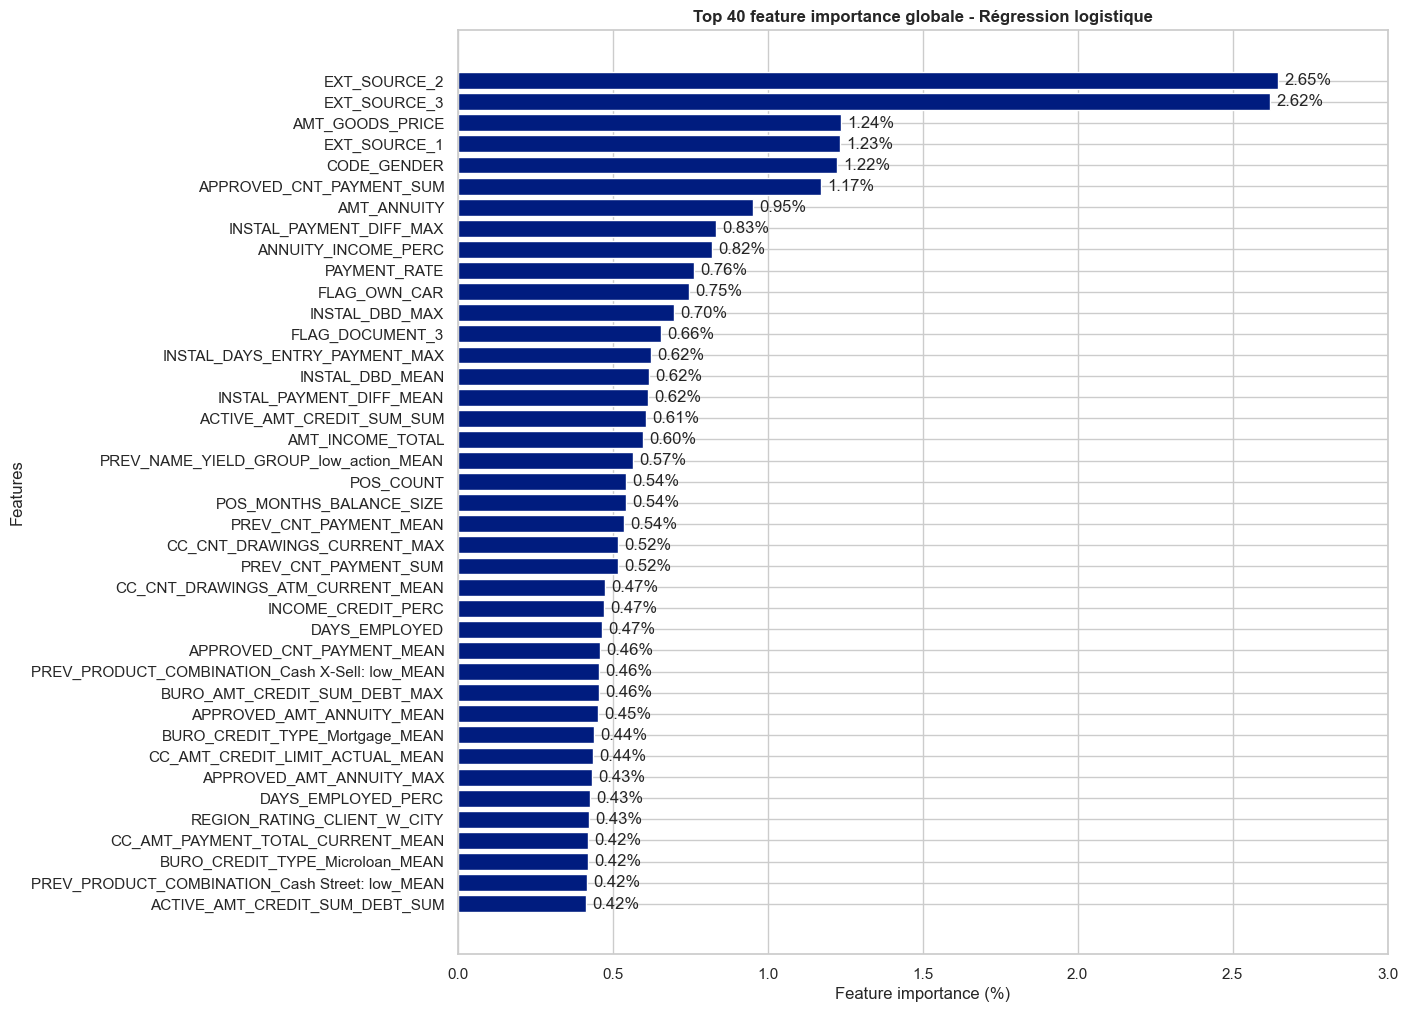

In [7]:
#On passe à la feature importance, pour ce faire on commence par enregistrer les noms de colonnes
feature_names = X.columns

#La feature importance est donnée par les coefficients absolus dans une régression logistique
feature_importances = np.abs(model_LR.coef_[0])

#On enregistre les feature names et importances dans un df, puis on calcule le pourcentage d'importance de chaque feature
feature_importance_LR = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
feature_importance_LR['Pourcentage'] = feature_importance_LR['Importance'] / feature_importance_LR['Importance'].sum() * 100

#Barplot sur le top 40
sns.set_theme(style="whitegrid", palette="dark")
plt.figure(figsize=(12, 12))
plt.barh(feature_importance_LR['Feature'][:40], feature_importance_LR['Pourcentage'][:40])
plt.xlabel('Feature importance (%)')
plt.ylabel('Features')
plt.title('Top 40 feature importance globale - Régression logistique', weight='bold')
plt.gca().invert_yaxis()  #Inverse l'axe pour que la feature la plus importante soit en haut

#Annotations
for index, valeur in enumerate(feature_importance_LR['Pourcentage'][:40]):
    plt.text(valeur + 0.02, index, f"{valeur:.2f}%", va='center')

#On augmente un peu l'espace en haut du plot pour faire place aux annotations
plt.xlim(0, 3)
plt.show()

In [8]:
pip install shap

  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


Analyse pour le client 19924 :


E:\Anaconda\Lib\site-packages\shap\plots\_force_matplotlib.py:390: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_names = data['outNames'][0]


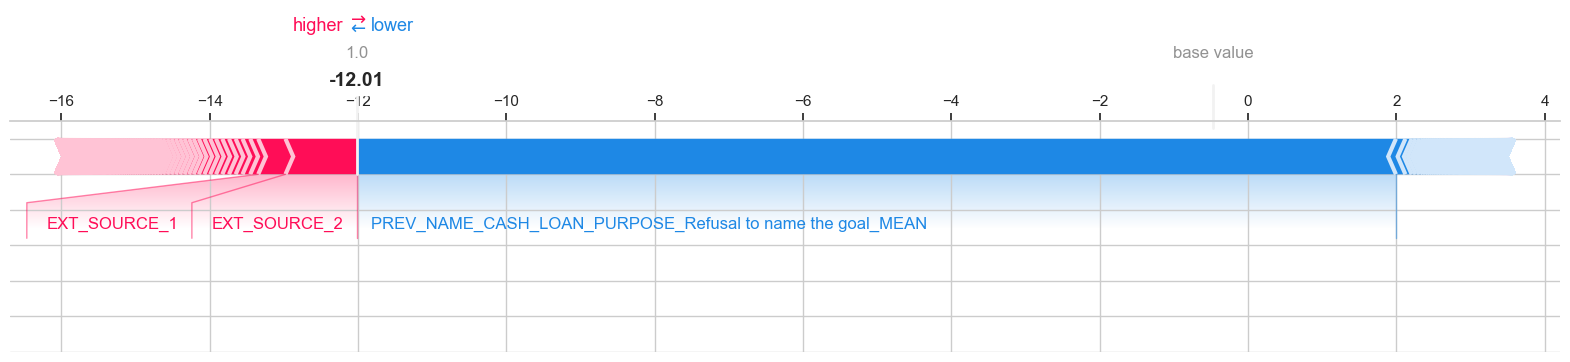


Analyse pour le client 48400 :


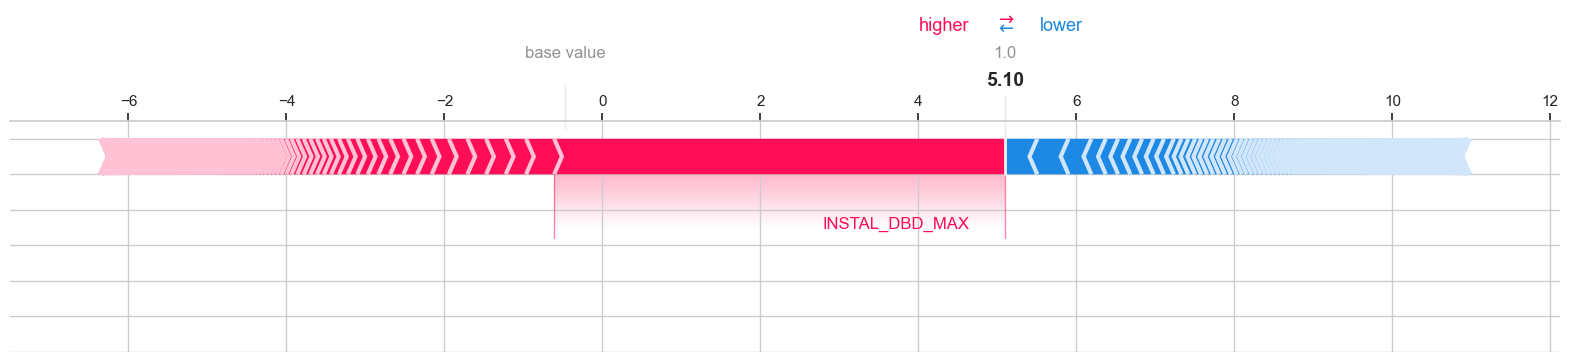


Analyse pour le client 3805 :


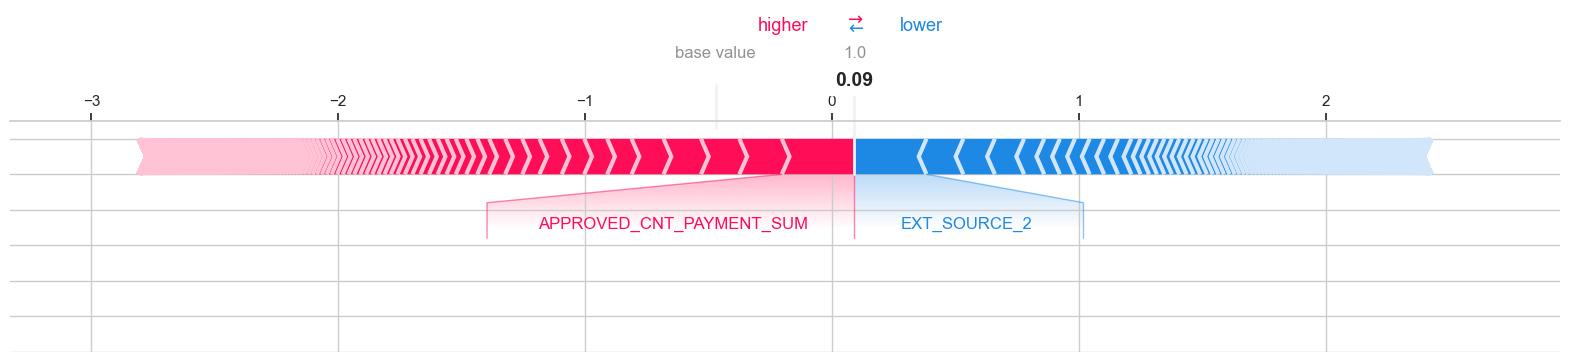

In [9]:
#Pour la feature importance locale, on va s'intéresser à 3 clients
#Un client positif typique, un négatif typique et un client proche du threshold
import shap

#On calcule les probabilités pour la classe 1
y_prob = model_LR.predict_proba(X_test_scaled)[:, 1]

#On sélectionne les 3 clients (rappel que 0 est notre classe positive donc argmin et max sont inversés)
positif_typique = np.argmin(y_prob)
negatif_typique = np.argmax(y_prob)
proche_threshold = np.abs(y_prob - threshold).argmin() #Cas le plus proche du threshold

#Calcul des valeurs sur l'ensemble des données
explainer = shap.LinearExplainer(model_LR, X_test_scaled)
shap_values = explainer.shap_values(X_test_scaled)

clients = [positif_typique, negatif_typique, proche_threshold]
for client in clients:
    print(f'Analyse pour le client {client} :')
    shap.initjs()
    #None pour retirer les valeurs car c'était illisible
    shap.force_plot(explainer.expected_value, shap_values[client], None, feature_names, X.iloc[client], matplotlib=True)
    print()

# III) LightGBM <a class="anchor" id="iii"></a>

In [10]:
import mlflow

#On récupère les runs pour l'expérience LightGBM
runs = mlflow.search_runs(experiment_names=["LightGBM"])

#On convertit en df et on filtre les métriques et paramètres
df_LGBM = pd.DataFrame(runs)
df_LGBM = df_LGBM.filter(regex=r'^(metrics\.|params\.)').sort_values(by="metrics.Score métier") #Rappel que le meilleur score métier est le score le plus faible

#On passe toutes les colonnes sauf fit time en numérique
cols_to_numeric = df_LGBM.columns.difference(['params.Fit time'])
df_LGBM[cols_to_numeric] = df_LGBM[cols_to_numeric].apply(pd.to_numeric)
df_LGBM.head(10)

,metrics.Score métier,metrics.AUC,metrics.Recall,params.learning_rate,params.max_depth,params.Threshold,params.subsample,params.Fit time,params.reg_alpha,params.reg_lambda,params.min_split_gain,params.num_leaves,params.n_estimators,params.min_child_weight,params.colsample_bytree
28,149733.0,0.787987,0.714642,0.048117,7,0.445262,0.825977,0:07:35,0.059512,0.046642,0.026540,30,667,37.737564,0.908631
8,149776.0,0.787319,0.681370,0.058096,8,0.473995,0.843314,0:08:20,0.081290,0.035737,0.080681,21,763,36.336350,0.985312
16,149931.0,0.787889,0.718792,0.051987,9,0.454320,0.814815,0:05:51,0.088028,0.027620,0.088460,32,431,32.929908,0.846502
11,150074.0,0.787736,0.702075,0.053929,9,0.462628,0.810933,0:06:58,0.092635,0.038638,0.086992,26,566,39.673206,0.978096
7,150293.0,0.787450,0.672870,0.055824,9,0.475900,0.867471,0:08:36,0.084398,0.036234,0.052616,23,768,41.144462,0.977735
33,150400.0,0.785469,0.680282,0.067927,9,0.449424,0.810487,0:07:42,0.052140,0.042895,0.010843,28,703,32.576108,0.847125
14,150453.0,0.787925,0.720040,0.047727,8,0.457353,0.843043,0:08:19,0.087229,0.031826,0.095555,21,645,36.254548,0.940432
29,150666.0,0.788283,0.739456,0.046137,7,0.428098,0.823268,0:07:46,0.062379,0.047482,0.032133,30,629,37.604421,0.903939
34,150834.0,0.786713,0.631098,0.067477,9,0.501876,0.792366,0:05:56,0.010645,0.045609,0.064053,38,445,33.030705,0.837156
32,150840.0,0.785160,0.700906,0.069523,9,0.422894,0.904814,0:07:48,0.055378,0.046374,0.010060,29,730,31.958868,0.839535


In [11]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import gc
import time
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from datetime import timedelta

#Début du timer
start_time = time.time()

#Configuration initiale de MLFlow
mlflow.set_experiment('Best_models')

#On sépare en X et y (à partir de df ici, car LightGBM fonctionne avec des NaNs)
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']

#On sépare en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#On centre et réduit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Pour récupérer le nombre de 0 et de 1 et définir les poids
target_counts = df['TARGET'].value_counts()
poids_classes = {0: 1, 1: target_counts.get(0) / target_counts.get(1)}

#Signature basée sur les données d'entrée et de sortie
signature = infer_signature(X_train_scaled, y_train)

#Les paramètres et le threshold
cols_params = df_LGBM.filter(regex=r'^params\.').columns.difference(['params.Fit time', 'params.Threshold'])  #On exclue les colonnes threshold et fit time
params = {col.replace('params.', ''): df_LGBM[col].iloc[0] for col in cols_params} #On conserve la valeur en 1ère ligne du df pour chaque paramètre
threshold = df_LGBM["params.Threshold"].iloc[0]

#On instancie (pas besoin de conserver le reste des study.best_params car C n'a pas d'incidence quand penalty=None)
model_LGBM = LGBMClassifier(**params, class_weight=poids_classes, random_state=42, verbose=0)

#On fit avec timer
start_fit_time = time.time()
model_LGBM.fit(X_train_scaled, y_train)
fit_time = time.time() - start_fit_time
fit_time = str(timedelta(seconds=int(fit_time)))

#On prédit le nombre de 0 en fonction du threshold
y_prob = model_LGBM.predict_proba(X_test_scaled)[:, 1]
y_pred = y_prob > threshold

#Métriques
auc = roc_auc_score(y_test, y_prob)
rec = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() #Pour aplatir la matrice
score = fp + 10 * fn #Score métier

#On enregistre les résultats
resultats.append({'Modèle': 'LightGBM',
                  'AUC': auc,
                  'Recall': rec,
                  'Score métier': score,
                  'Fit time': fit_time})

#On démarre l'exécution dans MLFlow
with mlflow.start_run(run_name='LightGBM'):
    #On enregistre les params, métriques et temps de fit
    mlflow.log_params(params)
    mlflow.log_param('Threshold', threshold)
    mlflow.log_metric('AUC', auc)
    mlflow.log_metric('Recall', rec)
    mlflow.log_metric('Score métier', score)
    mlflow.log_param('Fit time', fit_time) #Techniquement c'est une métrique, mais comme elle est au format str, log_metric ne la prend pas

    #Courbe ROC
    tfp, tvp, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10, 8))
    plt.plot(tfp, tvp, label=f'AUC: {auc:.2f}')
    plt.title('Courbe_ROC')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.legend(loc='lower right')
    plt.savefig('courbe_roc.png')
    plt.close()
    mlflow.log_artifact('courbe_roc.png')

    #On enregistre le modèle
    mlflow.sklearn.log_model(model_LR, 'LightGBM', signature=signature)

#On transforme les résultats en df
resultats_df = pd.DataFrame(resultats)

gc.collect()

#Fin du timer
end_time = time.time()
temps_total = end_time - start_time
temps_total = timedelta(seconds=int(temps_total))
print()
print('Temps total :', temps_total)
print()
resultats_df

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,Modèle,AUC,Recall,Score métier,Fit time
0,Logistic Regression,0.771819,0.668278,31381,0:00:54
1,LightGBM,0.788901,0.717623,29735,0:02:02


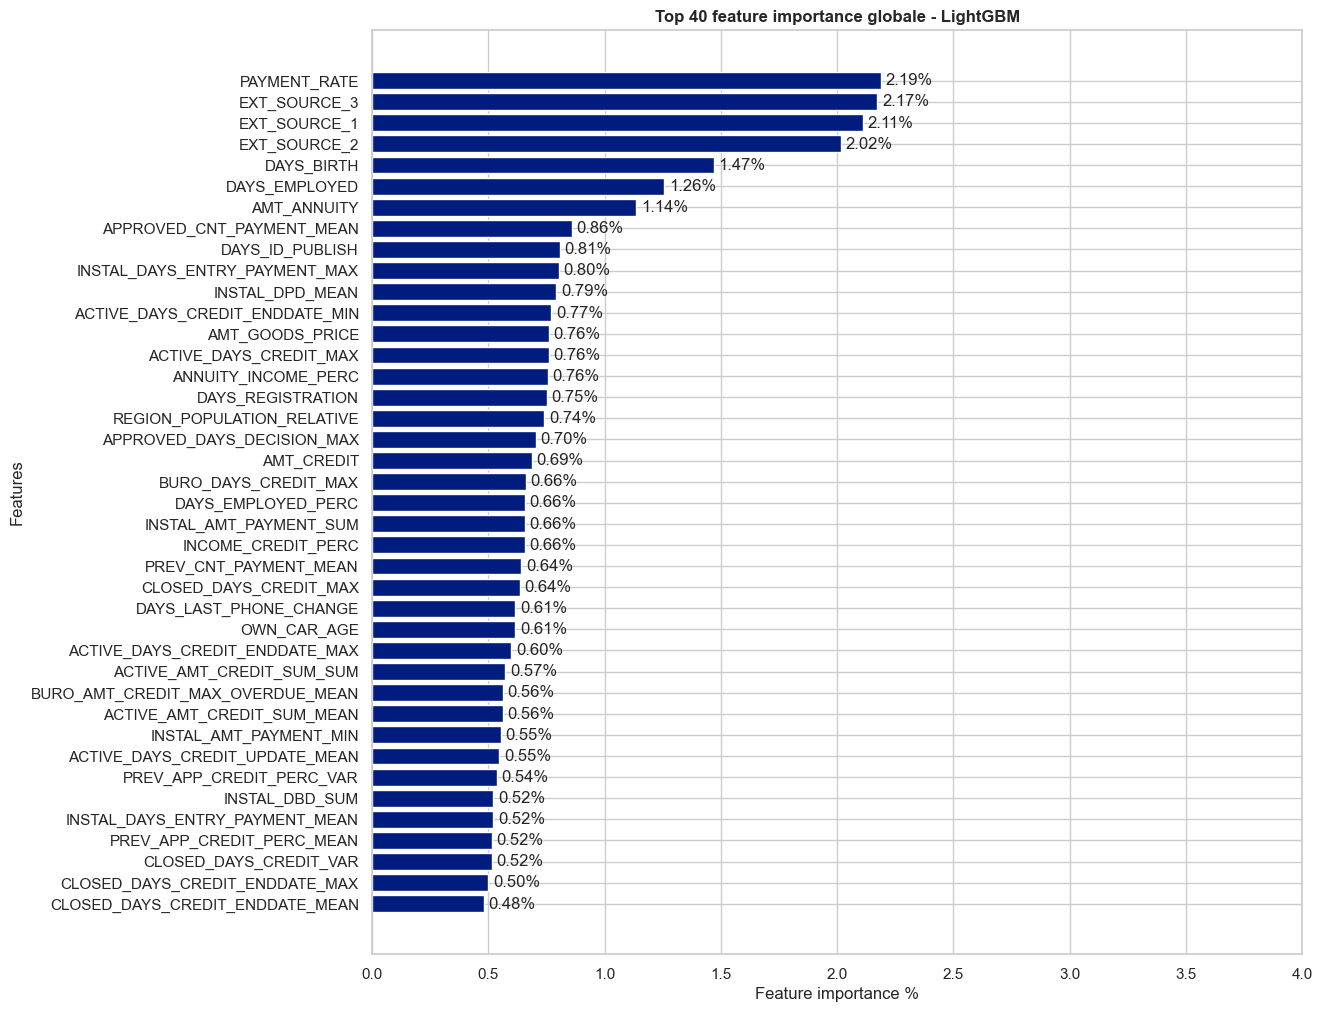

In [12]:
#On constate que LightGBM présente de meilleures métriques au prix d'un fit time un peu plus long
#C'est donc ce modèle que nous conservons pour la suite
#On passe à la feature importance, pour ce faire on commence par enregistrer les noms de colonnes
feature_names = X.columns

#La feature importance est donnée par l'attribut du même nom avec LightGBM
feature_importances = model_LGBM.feature_importances_

#On enregistre les feature names et importances dans un df puis on calcule le pourcentage d'importance de chaque feature
feature_importance_LGBM = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
feature_importance_LGBM['Pourcentage'] = feature_importance_LGBM['Importance'] / feature_importance_LGBM['Importance'].sum() * 100

#Barplot sur le top 40
sns.set_theme(style="whitegrid", palette="dark")
plt.figure(figsize=(12, 12))
plt.barh(feature_importance_LGBM['Feature'][:40], feature_importance_LGBM['Pourcentage'][:40])
plt.xlabel('Feature importance %')
plt.ylabel('Features')
plt.title('Top 40 feature importance globale - LightGBM', weight='bold')
plt.gca().invert_yaxis()  #Inverse l'axe pour que la feature la plus importante soit en haut

#Annotations
for index, valeur in enumerate(feature_importance_LGBM['Pourcentage'][:40]):
    plt.text(valeur + 0.02, index, f"{valeur:.2f}%", va='center')

#On augmente un peu l'espace en haut du plot pour faire place aux annotations
plt.xlim(0, 4)
plt.show()

Analyse pour le client 55824 :


E:\Anaconda\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


E:\Anaconda\Lib\site-packages\shap\plots\_force_matplotlib.py:390: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_names = data['outNames'][0]


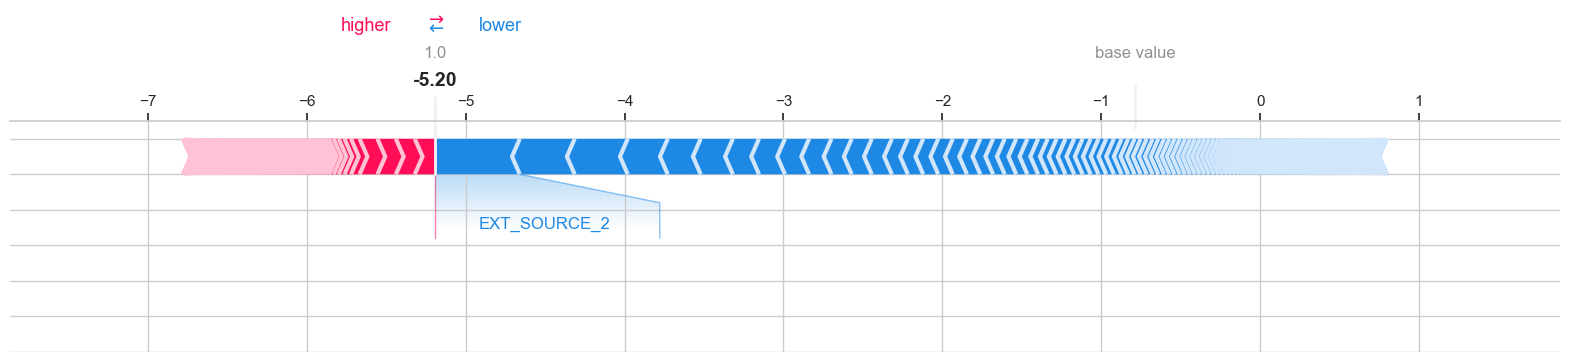


Analyse pour le client 12241 :


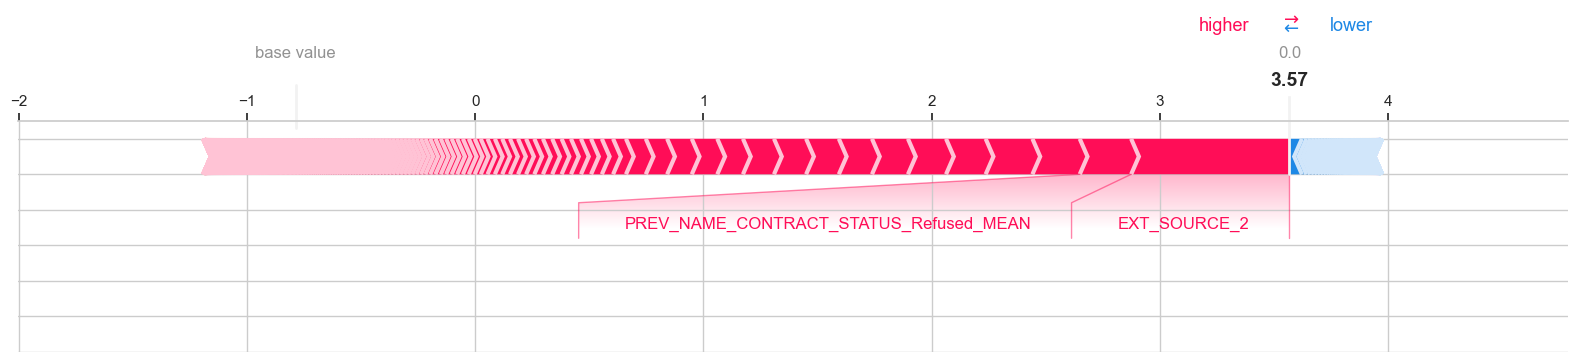


Analyse pour le client 57977 :


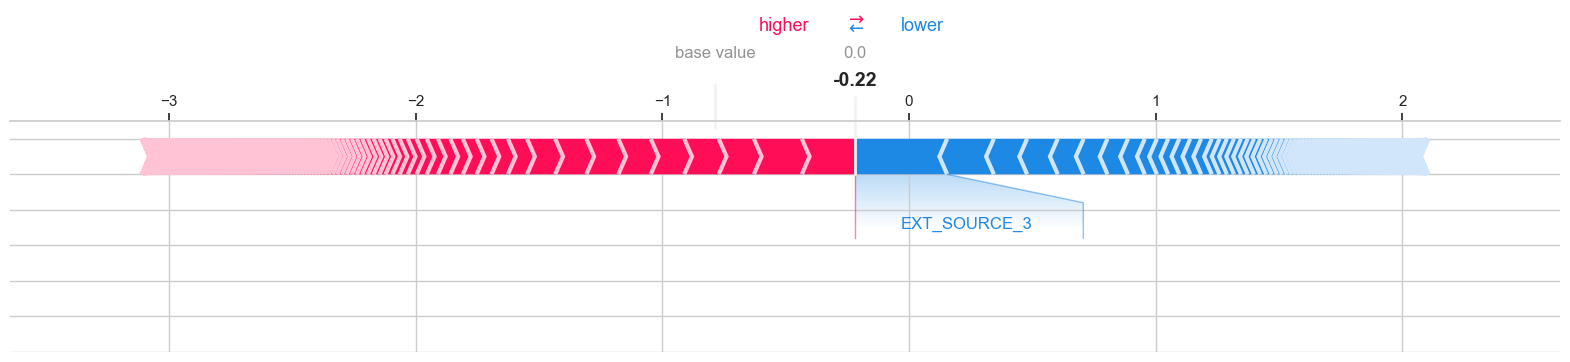

In [13]:
#Pour la feature importance locale, on va s'intéresser à 3 clients
#Un client positif typique, un négatif typique et un client proche du threshold
import shap

#On calcule les probabilités pour la classe 1
y_prob = model_LGBM.predict_proba(X_test_scaled)[:, 1]

#On sélectionne les 3 clients (rappel que 0 est notre classe positive donc argmin et max sont inversés)
positif_typique = np.argmin(y_prob)
negatif_typique = np.argmax(y_prob)
proche_threshold = np.abs(y_prob - threshold).argmin() #Cas le plus proche du threshold

#Calcul des valeurs sur l'ensemble des données
explainer = shap.TreeExplainer(model_LGBM)
shap_values = explainer.shap_values(X_test_scaled)

clients = [positif_typique, negatif_typique, proche_threshold]
for client in clients:
    print(f'Analyse pour le client {client} :')
    shap.initjs()
    #None pour retirer les valeurs car c'était illisible
    shap.force_plot(explainer.expected_value, shap_values[client], None, feature_names, X.iloc[client], matplotlib=True)
    print()

In [14]:
#Une dernière chose avant de passer à la suite, je souhaite regarder la distribution des prédictions correctes et incorrectes
is_correct = y_pred == y_test

#On créé un df
df_correct = pd.DataFrame({'Probabilité': y_prob,
                           'Classe Réelle': y_test,
                           'Classe Prédite': y_pred,
                           'Correct': is_correct}).reset_index(drop=True)
df_correct

,Probabilité,Classe Réelle,Classe Prédite,Correct
0,0.374431,0.0,False,True
1,0.358622,0.0,False,True
2,0.257102,0.0,False,True
3,0.322668,0.0,False,True
4,0.603895,0.0,True,False
...,...,...,...,...
61497,0.339900,0.0,False,True
61498,0.317401,0.0,False,True
61499,0.155711,0.0,False,True
61500,0.283980,1.0,False,False


In [15]:
#Probabilités min et max
min_prob = df_correct['Probabilité'].min()
max_prob = df_correct['Probabilité'].max()

#On créé 5 bins avant et après threshold
bins_below = np.linspace(min_prob, threshold, 6)
bins_above = np.linspace(threshold, max_prob, 6)

#On combine et on ajoute une colonne au df_correct
custom_bins = np.unique(np.concatenate((bins_below, bins_above)))
df_correct['Bin'] = pd.cut(df_correct['Probabilité'], bins=custom_bins, include_lowest=True)

#On groupe par bin et compte les prédictions correctes True et False
bin_results = df_correct.groupby(['Bin', 'Correct'], observed=False).size().unstack()

#On renomme les colonnes pour plus de clarté
bin_results.columns = ['Incorrect', 'Correct']

#On ajoute une colonne Total pour calculer les proportions
bin_results['Total'] = bin_results['Incorrect'] + bin_results['Correct']
bin_results['% Correct'] = (bin_results['Correct'] / bin_results['Total']) * 100
bin_results['% Incorrect'] = (bin_results['Incorrect'] / bin_results['Total']) * 100
bin_results

,Incorrect,Correct,Total,% Correct,% Incorrect
Bin,,,,,
"(0.00451, 0.0935]",59,6129,6188,99.046542,0.953458
"(0.0935, 0.181]",218,11197,11415,98.090232,1.909768
"(0.181, 0.269]",298,9672,9970,97.011033,2.988967
"(0.269, 0.357]",397,7692,8089,95.092100,4.907900
"(0.357, 0.445]",430,6132,6562,93.447120,6.552880
"(0.445, 0.551]",5756,658,6414,10.258809,89.741191
"(0.551, 0.656]",4482,747,5229,14.285714,85.714286
"(0.656, 0.762]",3302,878,4180,21.004785,78.995215
"(0.762, 0.867]",1839,899,2738,32.834186,67.165814


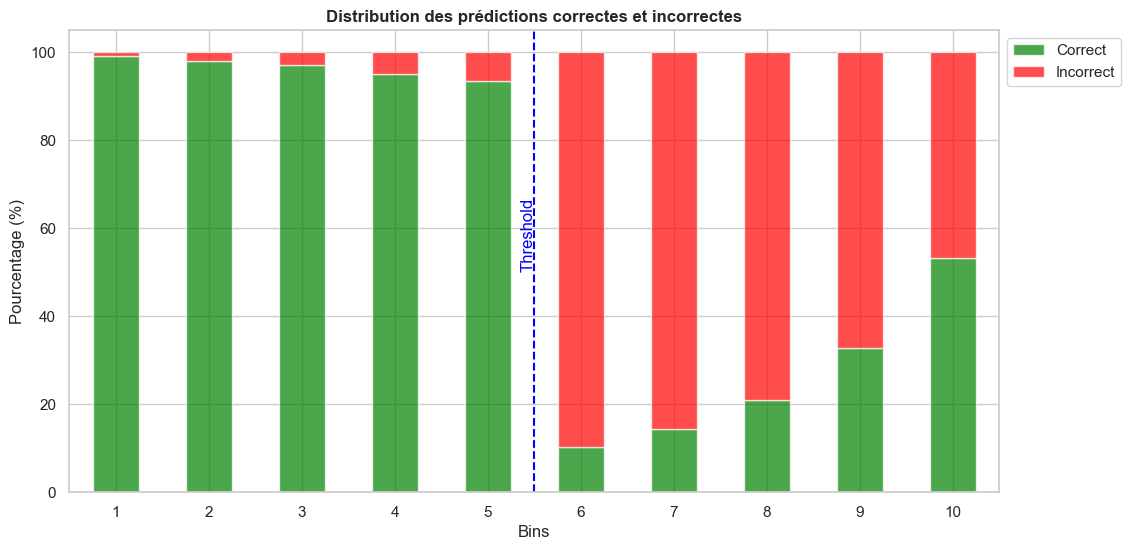

In [16]:
#Pour visualiser
bin_results[['% Correct', '% Incorrect']].plot(kind='bar', stacked=True, color=['green', 'red'], figsize=(12, 6), alpha=0.7)

# Ajouter des détails
plt.title('Distribution des prédictions correctes et incorrectes', weight='bold')
plt.xlabel('Bins')
plt.xticks(ticks=range(len(bin_results)), labels=[str(i) for i in range(1, 11)], rotation=0)
plt.ylabel('Pourcentage (%)')
plt.legend(['Correct', 'Incorrect'], bbox_to_anchor=(1, 1), loc='upper left')

#Ligne verticale délimitant le threshold
plt.axvline(x=4.5, color='blue', linestyle='--')
plt.text(4.35, 50, 'Threshold', color='blue', rotation=90, verticalalignment='bottom')

plt.show()



# IV) Exports <a class="anchor" id="iv"></a>
Comme mentionné plus haut, LightGBM présentant les meilleurs résultats, c'est ce modèle que nous conservons pour la suite.

In [17]:
import joblib

joblib.dump(scaler, './Artefacts/scaler.pkl')
joblib.dump(model_LGBM, './Artefacts/model.pkl')

['./Artefacts/model.pkl']